In [98]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit import ParameterVector


import warnings

warnings.filterwarnings("ignore")

In [103]:
df = datasets.load_iris()
dff = datasets.load_iris()
dff = pd.DataFrame(
    data=np.c_[dff["data"], dff["target"]], columns=dff["feature_names"] + ["target"]
)
df = pd.DataFrame(
    data=np.c_[df["data"], df["target"]], columns=df["feature_names"] + ["target"]
)
df_columns = df.columns.values[:-1]
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [104]:
x_train, x_test, y_train, y_test = train_test_split(
    df[df_columns], df["target"], test_size=0.30, random_state=0, stratify=df["target"]
)
x_val, x_test, y_val, y_test = train_test_split(
    x_train, y_train, test_size=0.5, random_state=0, stratify=y_train
)

y_train.value_counts(), y_val.value_counts(), y_test.value_counts()

(target
 2.0    35
 0.0    35
 1.0    35
 Name: count, dtype: int64,
 target
 2.0    18
 1.0    17
 0.0    17
 Name: count, dtype: int64,
 target
 0.0    18
 1.0    18
 2.0    17
 Name: count, dtype: int64)

In [105]:
dff[dff.duplicated(keep=False)]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
101,5.8,2.7,5.1,1.9,2.0
142,5.8,2.7,5.1,1.9,2.0


In [106]:
dff.drop_duplicates(inplace=True)

# Preprocessing

In this project we decided that we will use ``angle encoding`` because we don't have that many quibits to work with. Since angle enncoding needs the data to be on a scale between $[0, 2\pi]$, we will scale the data accordingly

In [107]:
# custom transformers for the pipeline
class RemoveDuplicates(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = pd.DataFrame(X)
        df = df.drop_duplicates()
        return df.values

In [108]:
scaler = MinMaxScaler(feature_range=(0, np.pi))
remove_duplicates = RemoveDuplicates()

pipe = Pipeline([("scaler", scaler), ("remove_duplicates", remove_duplicates)])

In [109]:
x_train = pipe.fit_transform(x_train)
x_val = pipe.transform(x_val)
x_test = pipe.transform(x_test)

# choosing a loss function

In [110]:
class IrisQNN_RealAmp:
    """
    Class representing an implementation of the
    Real Amplitudes QNN.

    Attributes:
        - n_qubits (Int): Number of qubits in the QNN.
        - n_layers (Int): Number of layers to the variational part.
        - n_params (Int): Number of parameters to the variational layer(s).
        - params (ParameterVector): List of the actual parameters for the variational layer(s).
        - qc (QuantumCircuit): The actual QNN / Quantum circuit

    Functions:
        - create_circuit(): Creates the QNN
        - _angle_encoding(): Priv. func to angle encode datapoint.
        - _add_variational_layer_real_amplitude(): Priv. func to add variational layer.
    """

    def __init__(self, n_qubits, n_layers):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.n_params = n_qubits * n_layers
        self.param_values = None
        self.params = ParameterVector("θ", self.n_params)
        self.qc = None

    def create_circuit(self, input_features):
        """
        A function for creating a Real Amp. circuit
        with the set parameters

        Parameters:
        - input_features (List[Float]): List of input_features to encode

        Calls:
        - _angle_encoding()
        - _add_variational_layer_real_amplitude()
        """
        # Initialize Quantum Circuit with new params and apply angle encoding:
        qc = QuantumCircuit(self.n_qubits)
        # self.params = ParameterVector("θ", self.n_params)
        self._angle_encoding(qc, input_features)

        # For each layer, add a variational layer:
        for layer in range(self.n_layers):
            self._add_variational_layer_real_amplitude(qc, layer)

        # Add measurement in the end
        qc.measure_all()

        self.qc = qc

    def _angle_encoding(self, qc, input_features):
        """
        A function to angle encode the qubits at init.
        of the Real Amp. circuit

        Parameters:
        - qc (QuantumCircuit): Circuit to apply encoding layer to
        - input_features(List[Float]): List of features to encode
        """
        # For each qubit, add Rx-Gate for encoding
        for qubit in range(qc.num_qubits):
            qc.rx(input_features[qubit], qubit)
        qc.barrier()

    def _add_variational_layer_real_amplitude(self, qc, layer_idx):
        """
        A function for applying a variational layer to
        the Real Amp. Circuit

        Parameters:
        - qc (QuantumCircuit): Circuit to apply var. layer to
        - layer_idx(Int): The index of the current layer
        """
        # Param offset to shift to next layer
        param_offset = layer_idx * self.n_qubits

        # Add Ry-Gate to each qubit with set of params
        for i in range(self.n_qubits):
            qc.ry(self.params[param_offset + i], i)

        # Add CX-Gate for entanglement
        for i in range(self.n_qubits - 1):
            qc.cx(i, i + 1)

        # Add barrier after each "variational" part:
        if layer_idx < self.n_layers - 1:
            qc.barrier()

    def get_parameter_count(self):
        """Getter function for returning the parameter count"""
        return self.n_params

In [111]:
class Loss_functions:
    """
    Class defining loss functions for usage in our training class

    Functions:
    - compute_loss_CE(): Loss function for computing Categorical Cross Entropy.
    """

    def compute_loss_CE(self, predicted, actual):
        """Compute Categorical Cross Entropy Loss"""
        # Epsilon to ensure we never encounter log(0)
        eps = 1e-10
        return -np.sum(
            [i * np.log(j if j != 0 else j + eps) for i, j in zip(actual, predicted)]
        )

In [ ]:
class Train_QNN:
    def __init__(
        self, X, y, QNN, loss_func, n_epochs, batch_size, learning_rate, patience
    ):
        self.X = X
        self.y = y.astype(int)
        self.QNN = QNN
        self.loss_func = loss_func
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.backend = QasmSimulator()
        self.batch_size = batch_size
        self.best_params = None
        self.patience = patience
        self._circuit_cache = {}

        self.n_classes = len(np.unique(self.y))
        self.actual_values = np.zeros((len(y), self.n_classes))
        self.actual_values[np.arange(len(y)), self.y] = 1

        # Initialize parameters if not already initialized
        if self.QNN.param_values is None:
            self.QNN.param_values = np.random.uniform(0, 2 * np.pi, self.QNN.n_params)

    def train(self, x_val, y_val, shots, epsilon, patience):
        train_losses = []
        val_losses = []

        # best_loss = np.inf
        best_val_loss = np.inf

        patience_counter = 0
        best_epoch = 0
        n_samples = len(self.X)
        patience = self.patience if self.patience is not None else patience

        y_val = np.array(y_val).astype(int)
        x_val = np.array(x_val)

        val_actual_values = np.zeros((len(y_val), self.n_classes))
        val_actual_values[np.arange(len(y_val)), y_val] = 1

        for epoch in range(self.n_epochs):
            print(f"------ EPOCH {epoch+1} ------")
            epoch_loss = 0.0

            indices = np.random.permutation(n_samples)

            for batch_start_idx in range(0, n_samples, self.batch_size):
                batch_indices = indices[
                    batch_start_idx : batch_start_idx + self.batch_size
                ]
                batch_loss = self._train_batch(batch_indices, shots, epsilon)
                epoch_loss += batch_loss

            avg_epoch_loss = epoch_loss / n_samples
            train_losses.append(avg_epoch_loss)

            val_loss = self._compute_validation_loss(x_val, y_val, shots)
            val_losses.append(val_loss)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.best_params = np.copy(self.QNN.param_values)
                best_epoch = epoch  # Save the best epoch
                patience_counter = 0
                print(
                    f"Epoch {epoch+1} - Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f} (Best)"
                )
            else:
                patience_counter += 1
                print(
                    f"Epoch {epoch+1} - Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f}"
                )
                if patience_counter >= patience:
                    print(
                        f"Early stopping triggered! No improvement for {patience} epochs"
                    )
                    print(
                        f"Restoring best model from epoch {best_epoch+1} with validation loss: {best_val_loss:.4f}"
                    )
                    self.QNN.param_values = np.copy(self.best_params)
                    # Truncate the losses to the best epoch + patience
                    train_losses = train_losses[: best_epoch + patience + 1]
                    val_losses = val_losses[: best_epoch + patience + 1]
                    break

        return train_losses, val_losses

    def _create_and_bind_circuit(self, x, params):
        cache_key = tuple(x)
        if cache_key not in self._circuit_cache:
            self.QNN.create_circuit(x)

            self._circuit_cache[cache_key] = self.QNN.qc.copy()
        else:
            self.QNN.qc = self._circuit_cache[cache_key].copy()

        if params is not None:
            self.QNN.qc.assign_parameters(
                {self.QNN.params[i]: params[i] for i in range(len(params))},
                inplace=True,
            )
        return self.QNN.qc

    def _train_batch(self, batch_indices, shots, epsilon):
        batch_gradients = np.zeros(self.QNN.n_params)
        batch_loss = 0.0

        batch_circuits = []
        for idx in batch_indices:
            qc = self._create_and_bind_circuit(self.X[idx], self.QNN.param_values)
            batch_circuits.append(qc)

        transpiled_circuits = transpile(batch_circuits, self.backend)
        results = self.backend.run(transpiled_circuits, shots=shots).result()

        for i, idx in enumerate(batch_indices):
            actual, decoded_result = self._bin_decode(results.get_counts(i), idx, shots)
            loss = self.loss_func.compute_loss_CE(decoded_result, actual)
            batch_loss += loss

            gradients = self._finiteDifference(epsilon, idx, shots)
            batch_gradients += gradients

        batch_gradients /= len(batch_indices)
        self._update_param_vals(self.learning_rate, batch_gradients)
        return batch_loss

    def _compute_validation_loss(self, x_val, y_val, shots):
        val_loss = 0.0
        n_val_samples = len(x_val)

        val_actual_values = np.zeros((len(y_val), self.n_classes))
        val_actual_values[np.arange(len(y_val)), y_val] = 1

        for idx in range(n_val_samples):
            qc = self._create_and_bind_circuit(x_val[idx], self.QNN.param_values)
            result = self._exec_circuit(qc, shots)
            actual, decoded_result = self._bin_decode(
                result.get_counts(), idx, shots, actual_values=val_actual_values
            )
            val_loss += self.loss_func.compute_loss_CE(decoded_result, actual)

        return val_loss / n_val_samples

    def _finiteDifference(self, epsilon, batch, shots):
        param_values = self.QNN.param_values
        n_params = self.QNN.n_params

        # Create all parameter variations at once
        forward_params = np.tile(param_values, (n_params, 1))
        backward_params = np.tile(param_values, (n_params, 1))

        # Apply epsilon shifts using vectorized operations
        forward_params += np.eye(n_params) * epsilon
        backward_params -= np.eye(n_params) * epsilon

        # Create and execute all circuits in one batch
        forward_circuits = [
            self._create_and_bind_circuit(self.X[batch], params)
            for params in forward_params
        ]
        backward_circuits = [
            self._create_and_bind_circuit(self.X[batch], params)
            for params in backward_params
        ]

        all_circuits = forward_circuits + backward_circuits
        transpiled_circuits = transpile(all_circuits, self.backend)
        results = self.backend.run(transpiled_circuits, shots=shots).result()

        forward_losses = np.array(
            [
                self.loss_func.compute_loss_CE(
                    *self._bin_decode(results.get_counts(i), batch, shots)
                )
                for i in range(n_params)
            ]
        )

        backward_losses = np.array(
            [
                self.loss_func.compute_loss_CE(
                    *self._bin_decode(results.get_counts(i + n_params), batch, shots)
                )
                for i in range(n_params)
            ]
        )

        return (forward_losses - backward_losses) / (2 * epsilon)

    def _update_param_vals(self, alpha, gradients):
        self.QNN.param_values = self.QNN.param_values - (alpha * np.array(gradients))

    def _exec_circuit(self, qc, shots):
        transpiled_qc = transpile(qc, self.backend)
        job = self.backend.run(transpiled_qc, shots=shots)
        return job.result()

    def _bin_decode(self, result, y_idx, shots, actual_values=None):
        probabilities = np.zeros(self.n_classes)

        for bitstring, count in result.items():
            classIndex = int(bitstring, 2) % self.n_classes
            probabilities[classIndex] += count

        probabilities /= shots

        if actual_values is not None:
            actual = self.actual_values[y_idx]
        else:
            actual = self.actual_values[y_idx]

        return actual, probabilities

In [113]:
import seaborn as sns


def evaluate_qnn(trainer, X_val, y_val, shots=1000):
    predictions = []
    val_loss = 0.0
    correct_predictions = 0
    confusion_mat = np.zeros((3, 3), dtype=int)

    # Convert to numpy arrays if they aren't already
    X_val = np.array(X_val)
    y_val = np.array(y_val).astype(int)

    eval_params = (
        trainer.best_params
        if trainer.best_params is not None
        else trainer.QNN.param_values
    )

    for idx in range(len(X_val)):
        try:
            trainer.QNN.create_circuit(X_val[idx])

            trainer.QNN.qc.assign_parameters(
                {
                    trainer.QNN.params[i]: eval_params[i]
                    for i in range(len(eval_params))
                },
                inplace=True,
            )

            transpiled_qc = transpile(trainer.QNN.qc, trainer.backend)
            job = trainer.backend.run(transpiled_qc, shots=shots)
            result = job.result()

            actual = np.zeros(3)
            actual[int(y_val[idx])] = 1  # Ensure integer indexing
            counts = result.get_counts()

            probabilities = np.zeros(3)
            for bitstring, count in counts.items():
                classIndex = int(bitstring, 2) % 3
                probabilities[classIndex] += count / shots
            probabilities /= np.sum(probabilities)

            predictions.append(probabilities)

            val_loss += trainer.loss_func.compute_loss_CE(probabilities, actual)

            predicted_class = np.argmax(probabilities)
            true_class = int(y_val[idx])  # Ensure integer for indexing

            confusion_mat[true_class][predicted_class] += 1

            if predicted_class == true_class:
                correct_predictions += 1

        except Exception as e:
            print(f"Error processing sample {idx}:")
            print(f"Full error: {type(e).__name__}: {str(e)}")
            print(f"X_val[idx]: {X_val[idx]}")
            print(f"y_val[idx]: {y_val[idx]}")
            continue

    accuracy = correct_predictions / len(X_val)
    avg_loss = val_loss / len(X_val)

    return {
        "accuracy": accuracy,
        "loss": avg_loss,
        "predictions": predictions,
        "confusion_matrix": confusion_mat,
    }


def plot_evaluation_results(eval_results, train_losses=None):
    plt.figure(figsize=(12, 5))

    # Plot confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(
        eval_results["confusion_matrix"],
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Class 0", "Class 1", "Class 2"],
        yticklabels=["Class 0", "Class 1", "Class 2"],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

    # Plot training losses if provided
    if train_losses is not None:
        plt.subplot(1, 2, 2)
        plt.plot(train_losses)
        plt.title("Training Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")

    plt.tight_layout()
    plt.show()

In [115]:
myQNN = IrisQNN_RealAmp(4, 5)
loss_func = Loss_functions()
patience = 10
a = Train_QNN(
    x_train,
    y_train,
    myQNN,
    loss_func,
    n_epochs=30,
    batch_size=len(x_train),
    learning_rate=0.7,
    patience=patience,
)
trainer = a.train(x_val, y_val, 1000, 0.02, patience=patience)

------ EPOCH 1 ------
Epoch 1 - Train Loss: 1.1488, Val Loss: 1.1592 (Best)
------ EPOCH 2 ------
Epoch 2 - Train Loss: 1.2323, Val Loss: 1.1170 (Best)
------ EPOCH 3 ------
Epoch 3 - Train Loss: 1.1413, Val Loss: 1.2123
------ EPOCH 4 ------
Epoch 4 - Train Loss: 1.4962, Val Loss: 1.0973 (Best)
------ EPOCH 5 ------
Epoch 5 - Train Loss: 1.0341, Val Loss: 1.1716
------ EPOCH 6 ------
Epoch 6 - Train Loss: 1.0992, Val Loss: 1.2629
------ EPOCH 7 ------
Epoch 7 - Train Loss: 1.2350, Val Loss: 1.0976
------ EPOCH 8 ------
Epoch 8 - Train Loss: 1.2953, Val Loss: 1.1636
------ EPOCH 9 ------
Epoch 9 - Train Loss: 1.0999, Val Loss: 1.1890
------ EPOCH 10 ------
Epoch 10 - Train Loss: 1.4015, Val Loss: 1.1360
------ EPOCH 11 ------
Epoch 11 - Train Loss: 0.8668, Val Loss: 1.2566
------ EPOCH 12 ------
Epoch 12 - Train Loss: 0.9573, Val Loss: 1.0706 (Best)
------ EPOCH 13 ------
Epoch 13 - Train Loss: 1.0720, Val Loss: 1.1654
------ EPOCH 14 ------
Epoch 14 - Train Loss: 1.3058, Val Loss: 1.1

In [116]:
eval_results = evaluate_qnn(
    a,
    x_test,
    y_test,
)
eval_results2 = evaluate_qnn(
    a,
    x_val,
    y_val,
)
eval_results3 = evaluate_qnn(
    a,
    x_train,
    y_train,
)

In [117]:
test1, test2, test3 = (
    eval_results["accuracy"],
    eval_results2["accuracy"],
    eval_results3["accuracy"],
)
print(f"Test accuracy: {test1}")
print(f"Validation accuracy: {test2}")
print(f"Train accuracy: {test3}")

Test accuracy: 0.4716981132075472
Validation accuracy: 0.5576923076923077
Train accuracy: 0.5714285714285714


In [118]:
train, val = trainer
val

[1.159221163333981,
 1.1169915477413386,
 1.2123208088160764,
 1.097316688344099,
 1.1715982562438805,
 1.2628657597887185,
 1.0975953153431948,
 1.1636354639991882,
 1.188999275314393,
 1.1359941276663994,
 1.256570245299186,
 1.0705528786462022,
 1.1653628027169876,
 1.1571196423738497,
 1.1268707233216921,
 1.063566364341121,
 1.1627992483970908,
 1.0875941184904954,
 1.1357569010375206,
 1.1836451654059432,
 1.1543982911348258,
 1.2382214307243211,
 1.2463311400409534,
 1.2041192423220064,
 1.2528457582941053,
 1.2575777387678346]

Accuracy on testing data: 0.4716981132075472
----------------------------------------


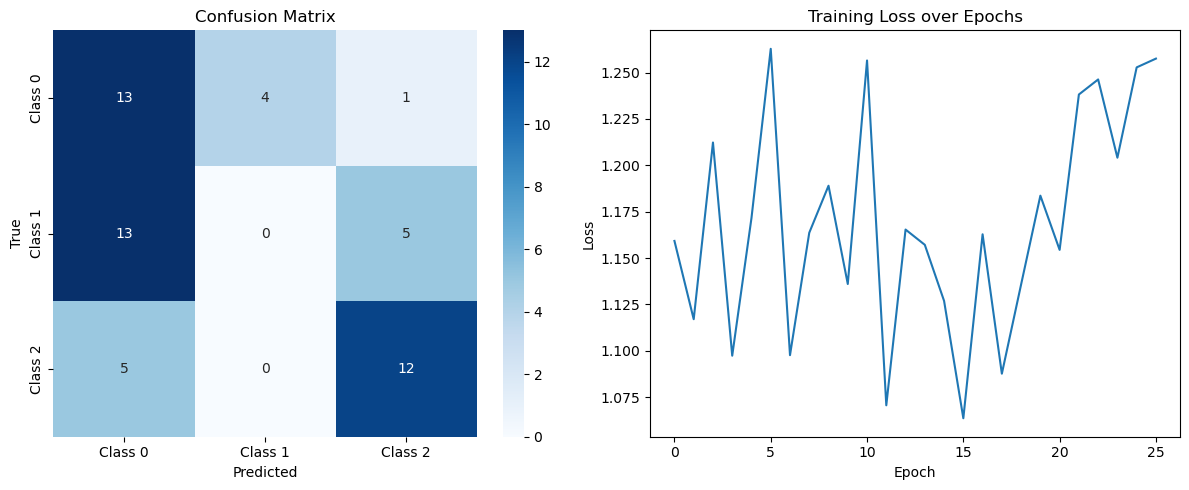

In [119]:
print(f"Accuracy on testing data: {eval_results['accuracy']}")
print("--" * 20)
plot_evaluation_results(eval_results, val)